In [2]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
SCRNA_DIR = '../data/zhu-2019/Fetal_Forebrain/FB_RNA/'
SCATAC_DIR = '../data/zhu-2019/Fetal_Forebrain/FB_DNA/'
META_PATH = '../data/zhu-2019/Fetal_Forebrain/Forebrain_Adult_Mix_Embeddings.xls'

# MetaData

In [5]:
metadata = pd.read_csv(META_PATH, sep='\t', index_col='ID')
metadata.head()

,Stage,Rep,Ident,Dim1,Dim2
ID,,,,,
01:30:88:16,Adult,2,7,-1.786314,-3.087099
02:03:35:21,Adult,1,5,-0.883296,-0.008344
02:03:73:23,Adult,1,4,1.599593,-2.082603
02:04:46:38,Adult,2,3,3.978912,-0.334285
02:04:66:36,Adult,2,4,-1.511953,-0.329731


# scRNA-seq Data

In [6]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_ids', cache=True)
scrna.obs = metadata
scrna

CPU times: user 15.3 s, sys: 252 ms, total: 15.6 s
Wall time: 15.4 s


AnnData object with n_obs × n_vars = 25845 × 29836
    obs: 'Stage', 'Rep', 'Ident', 'Dim1', 'Dim2'
    var: 'gene_symbols'

In [7]:
scrna.var.head()

,gene_symbols
ENSMUSG00000000001,Gnai3
ENSMUSG00000000003,Pbsn
ENSMUSG00000000028,Cdc45
ENSMUSG00000000031,H19
ENSMUSG00000000037,Scml2


## Data Cleaning

In [8]:
cell_types_map = {
    1: "AS",
    2: "MG",
    3: "OC",
    4: "Ex1",
    5: "Ex2",
    6: "Ex3",
    7: "In1",
    8: "In2",
    9: "In3"
}

In [9]:
scrna.obs = scrna.obs.rename(columns={'Ident': 'cell_type'})

In [10]:
scrna.obs['cell_type'] = scrna.obs['cell_type'].apply(lambda x: cell_types_map[x])

In [11]:
scrna.obs['Rep'] = scrna.obs['Rep'].astype('category')
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [12]:
scrna.obsm['X_umap'] = scrna.obs[['Dim1', 'Dim2']].to_numpy()

In [13]:
scrna

AnnData object with n_obs × n_vars = 25845 × 29836
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2'
    var: 'gene_symbols'
    obsm: 'X_umap'

# Quality Control

In [14]:
scrna.var_names_make_unique()

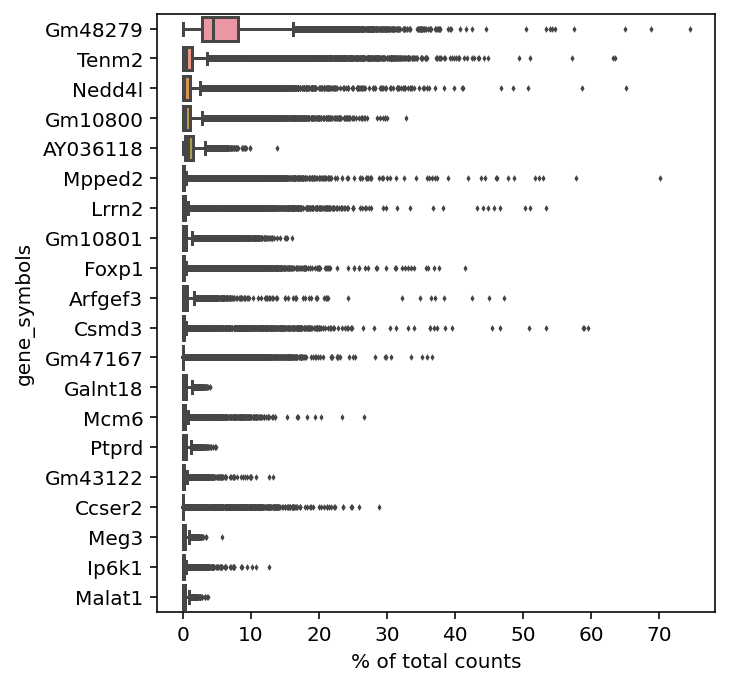

In [16]:
sc.pl.highest_expr_genes(scrna, n_top=20, gene_symbols='gene_symbols')

In [17]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 23440 × 28309
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'n_genes'
    var: 'gene_symbols', 'n_cells'
    obsm: 'X_umap'

## Qalculate QC metrics including Mitochondrial genes

In [26]:
scrna.var['mt'] = scrna.var['gene_symbols'].str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 23440 × 28309
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_umap'

... storing 'Stage' as categorical
... storing 'gene_symbols' as categorical


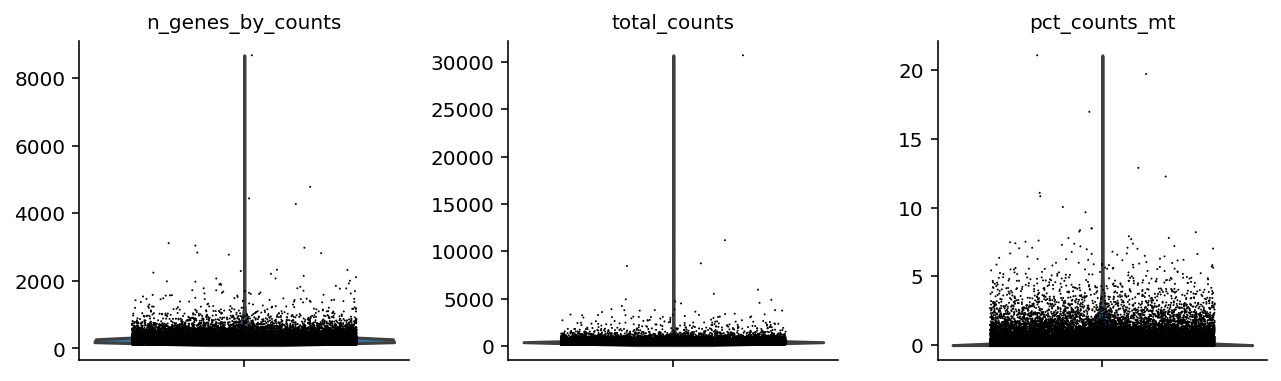

In [27]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

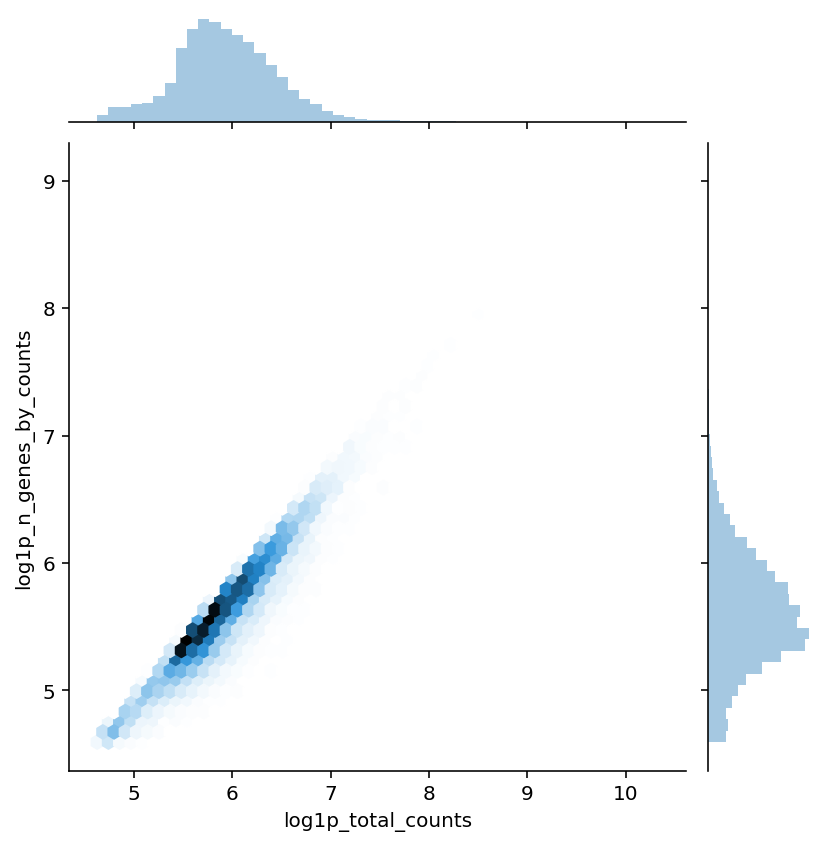

In [28]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex');

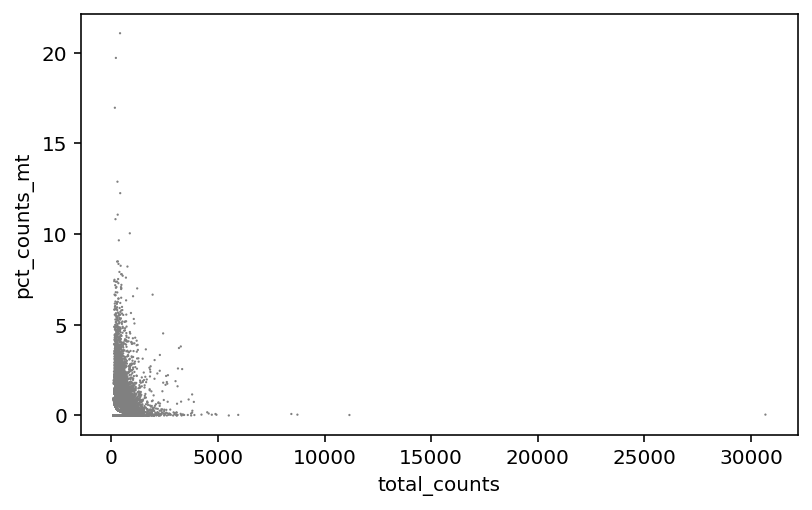

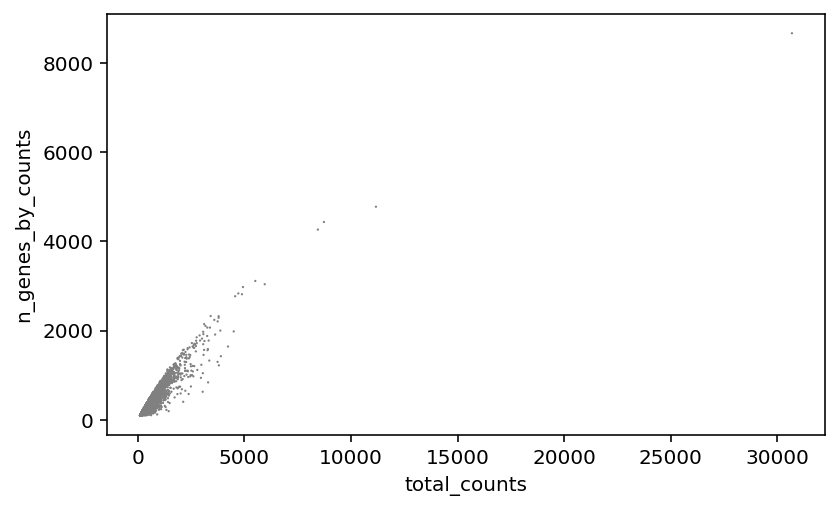

In [29]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out high mitochondrial samples and samples with highest number of genes:

In [30]:
scrna = scrna[scrna.obs.n_genes_by_counts < 1500, :]
scrna = scrna[scrna.obs.pct_counts_mt < 5, :]
scrna

View of AnnData object with n_obs × n_vars = 23281 × 28309
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_umap'

## Normalization

In [31]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

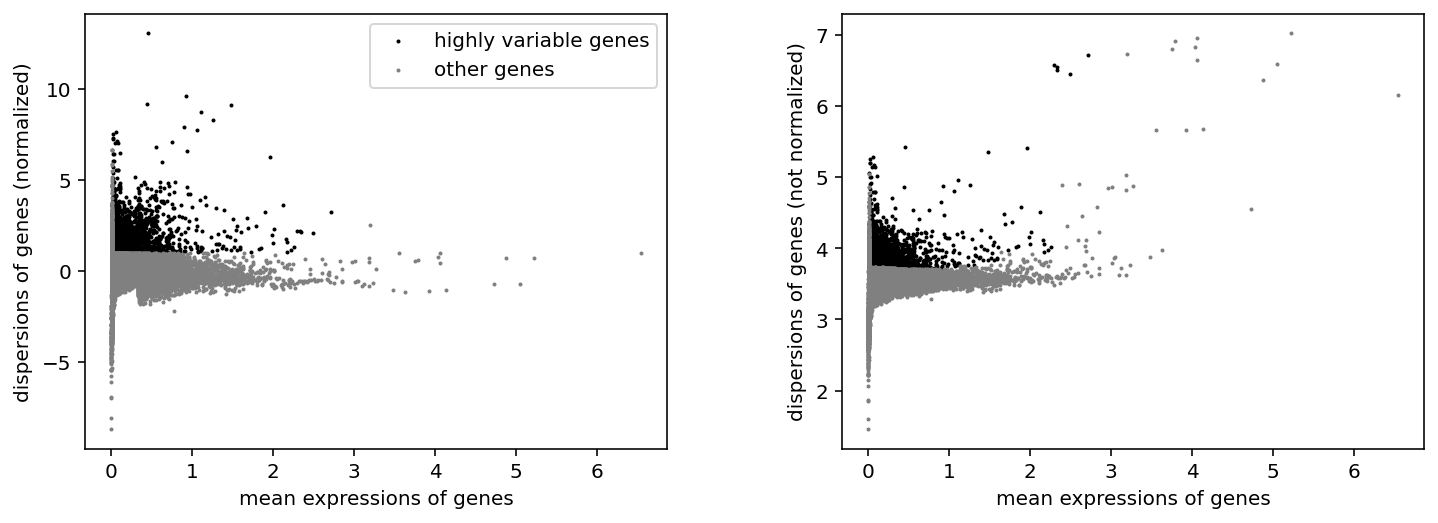

In [32]:
sc.pp.highly_variable_genes(scrna, min_mean=0.0125, max_mean=3, min_disp=1)
sc.pl.highly_variable_genes(scrna)

In [33]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 23281 × 2777
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 'X_umap'

## Visualization

### UMAP using coordinates provided by the authors

Trying to set attribute `.uns` of view, copying.


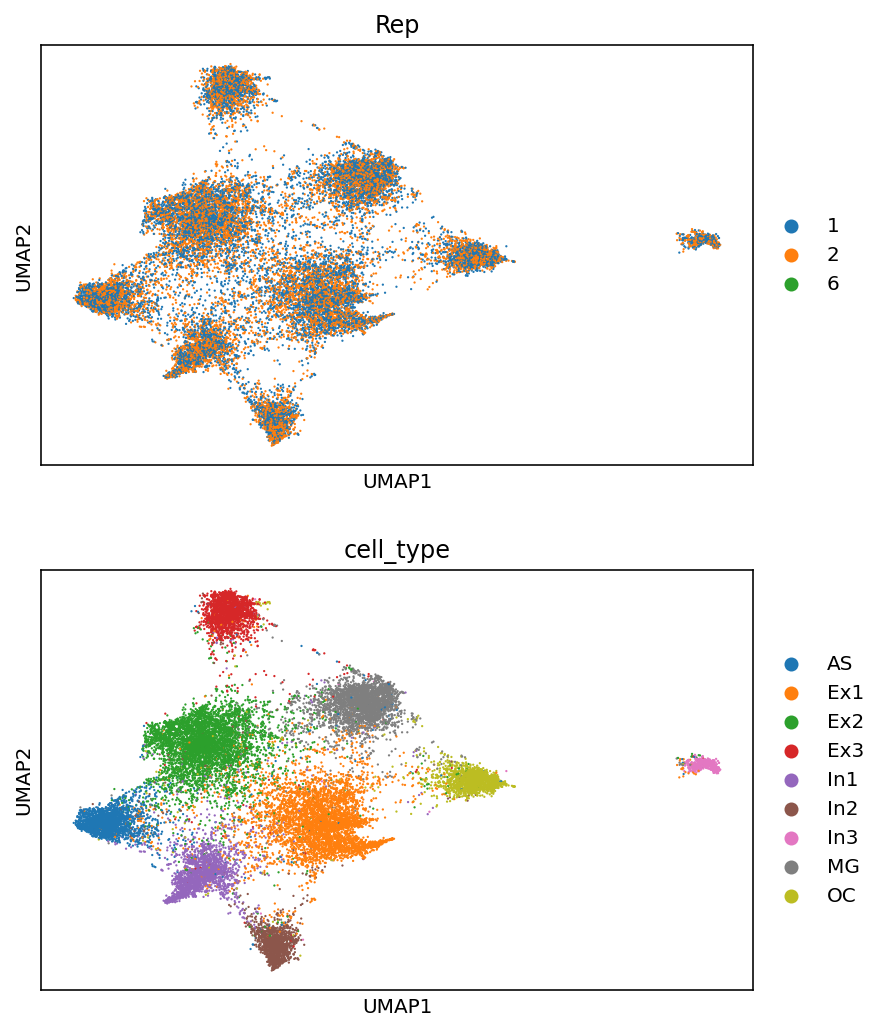

In [34]:
sc.pl.umap(scrna, color=['Rep', 'cell_type'])

### Running UMAP

In [35]:
sc.pp.neighbors(scrna, random_state=42)
sc.tl.umap(scrna, random_state=42)

         Falling back to preprocessing with `sc.pp.pca` and default params.


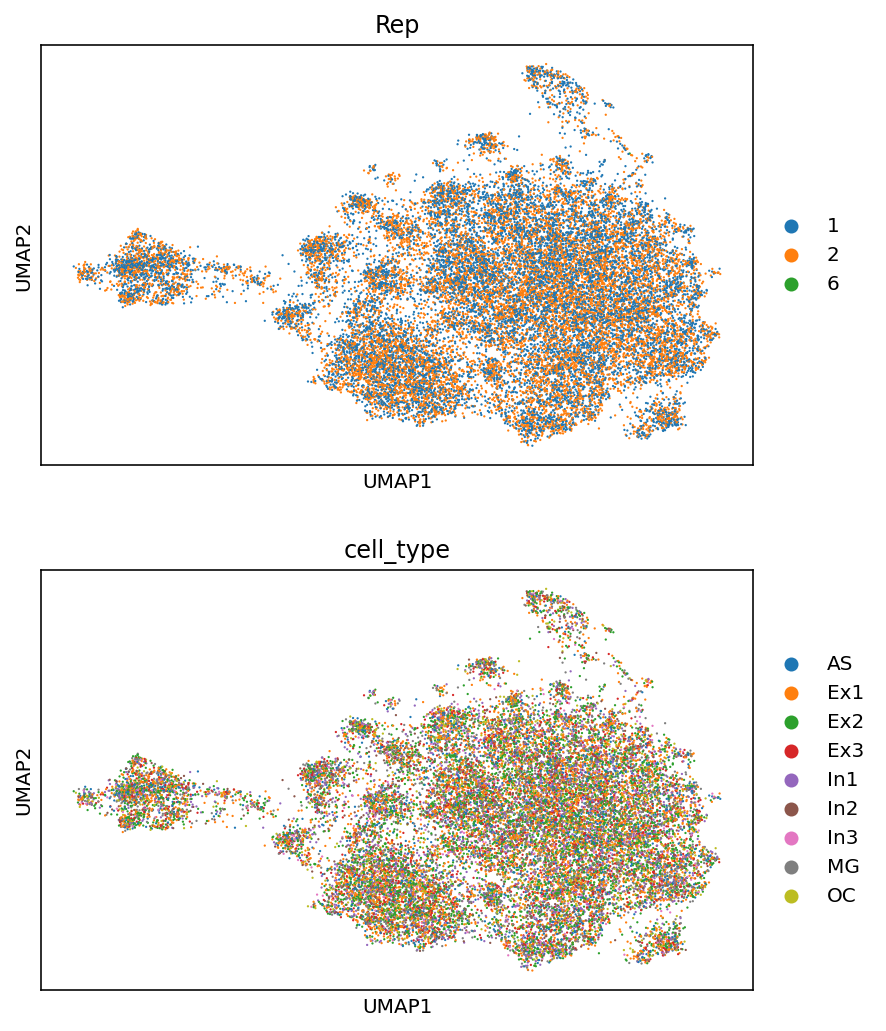

In [36]:
sc.pl.umap(scrna, color=['Rep', 'cell_type'])

---
# scATAC-seq Data

In [40]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)
scatac.obs = metadata
scatac

CPU times: user 1min 25s, sys: 2.96 s, total: 1min 28s
Wall time: 1min 27s


AnnData object with n_obs × n_vars = 25845 × 2637315
    obs: 'Stage', 'Rep', 'Ident', 'Dim1', 'Dim2'
    var: 'gene_ids'

In [41]:
scatac.var.head()

,gene_ids
chr10:10000000-10001000,chr10:10000000-10001000
chr10:100000000-100001000,chr10:100000000-100001000
chr10:100001000-100002000,chr10:100001000-100002000
chr10:100002000-100003000,chr10:100002000-100003000
chr10:100003000-100004000,chr10:100003000-100004000


## Data Cleaning

In [45]:
scatac.obs = scatac.obs.rename(columns={'Ident': 'cell_type'})

In [46]:
scatac.obs['cell_type'] = scatac.obs['cell_type'].apply(lambda x: cell_types_map[x])

In [47]:
scatac.obs['Rep'] = scatac.obs['Rep'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

In [48]:
scatac.obsm['X_umap'] = scatac.obs[['Dim1', 'Dim2']].to_numpy()

In [49]:
scatac

AnnData object with n_obs × n_vars = 25845 × 2637315
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

## Binarization

In [50]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

CPU times: user 3.98 s, sys: 344 ms, total: 4.32 s
Wall time: 4.32 s


AnnData object with n_obs × n_vars = 25845 × 2637315
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2'
    var: 'gene_ids'
    obsm: 'X_umap'

## Quality Control

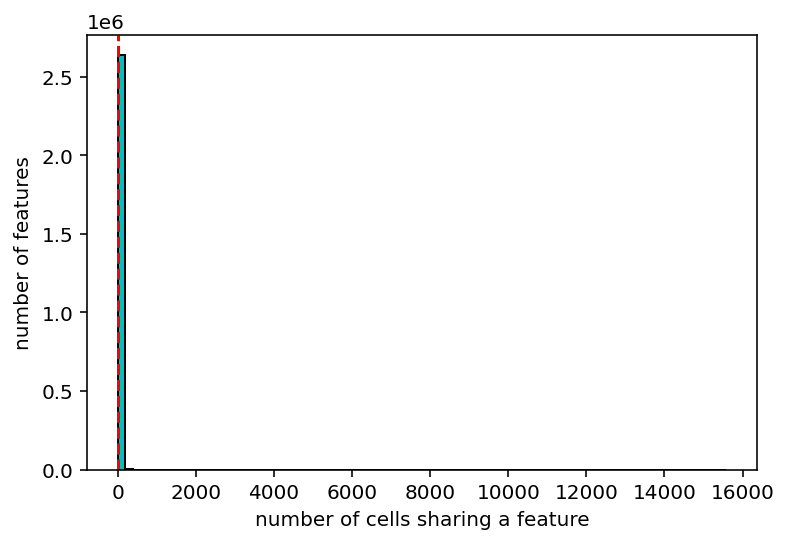

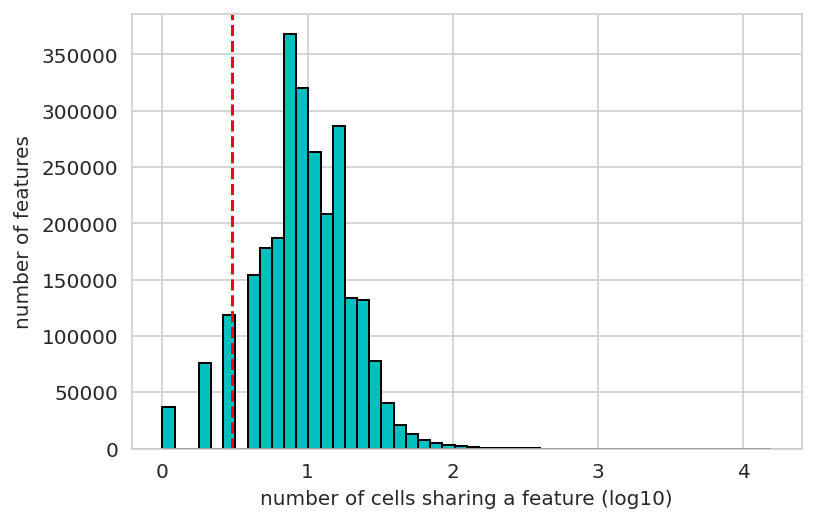

In [51]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=3)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=3)

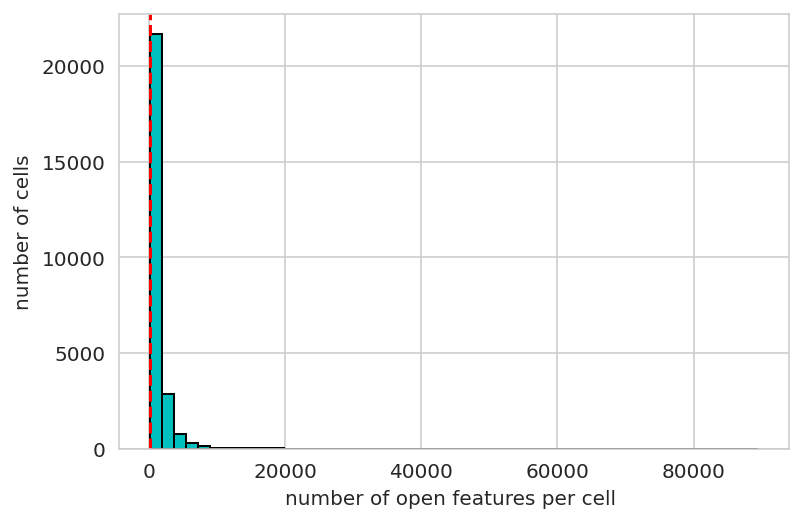

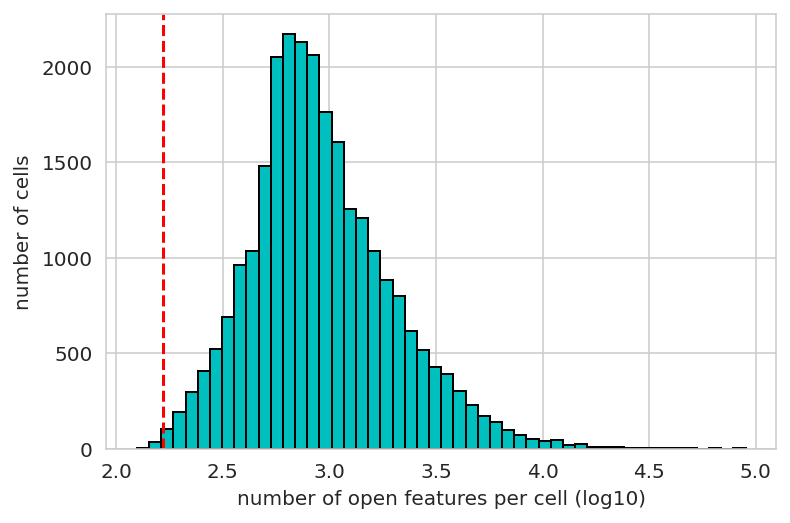

In [52]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=165)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=165)

## Filter low quality cells and peaks

In [53]:
epi.pp.filter_cells(scatac, min_features=165)
epi.pp.filter_features(scatac, min_cells=3)
scatac

AnnData object with n_obs × n_vars = 25792 × 2524268
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells'
    obsm: 'X_umap'

In [54]:
scatac.obs['nb_features'].describe()

count    25792.000000
mean      1309.805327
std       1829.914116
min        165.000000
25%        560.000000
50%        831.000000
75%       1429.250000
max      89499.000000
Name: nb_features, dtype: float64

In [55]:
scatac.var['commonness'].describe()

count    2.524268e+06
mean     1.331145e+01
std      4.881017e+01
min      3.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.600000e+01
max      1.558300e+04
Name: commonness, dtype: float64

In [56]:
scatac.var['commonness'].median()

10.0

In [57]:
scatac = scatac[:, scatac.var['commonness'] > 10]
scatac

View of AnnData object with n_obs × n_vars = 25792 × 1198840
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells'
    obsm: 'X_umap'

## Selecting variable peaks

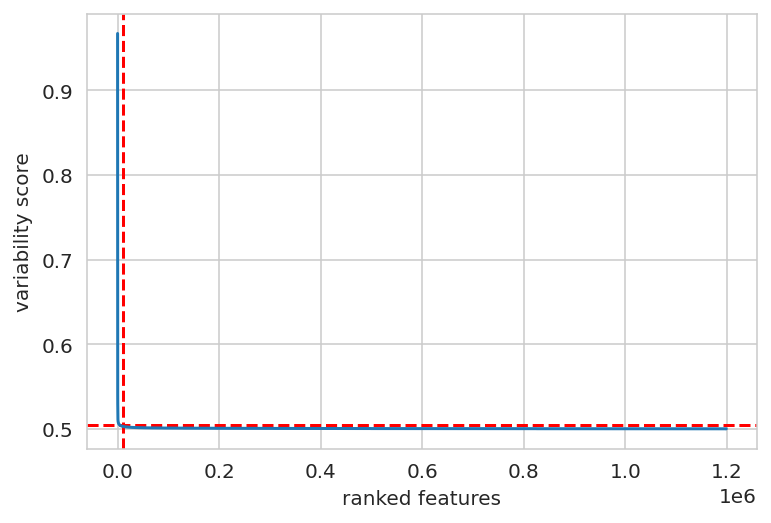

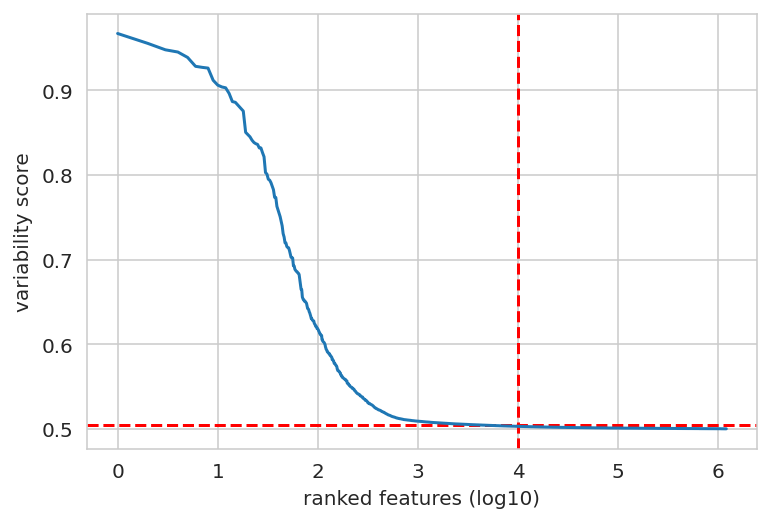

In [59]:
min_score_value = 0.505
nb_feature_selected = 10000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

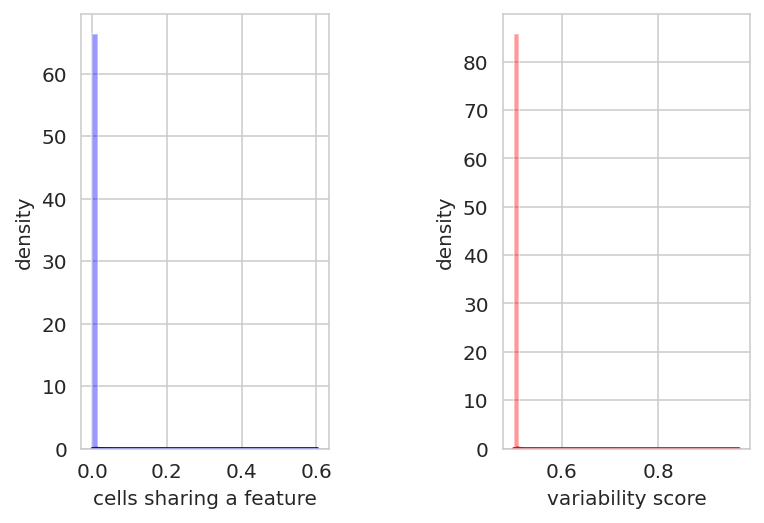

CPU times: user 3.22 s, sys: 264 ms, total: 3.48 s
Wall time: 3.46 s


In [60]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

In [61]:
scatac

View of AnnData object with n_obs × n_vars = 25792 × 10054
    obs: 'Stage', 'Rep', 'cell_type', 'Dim1', 'Dim2', 'nb_features'
    var: 'gene_ids', 'commonness', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

## Visualization

### UMAP using coordinates provided by the authors

Trying to set attribute `.obs` of view, copying.
... storing 'Stage' as categorical


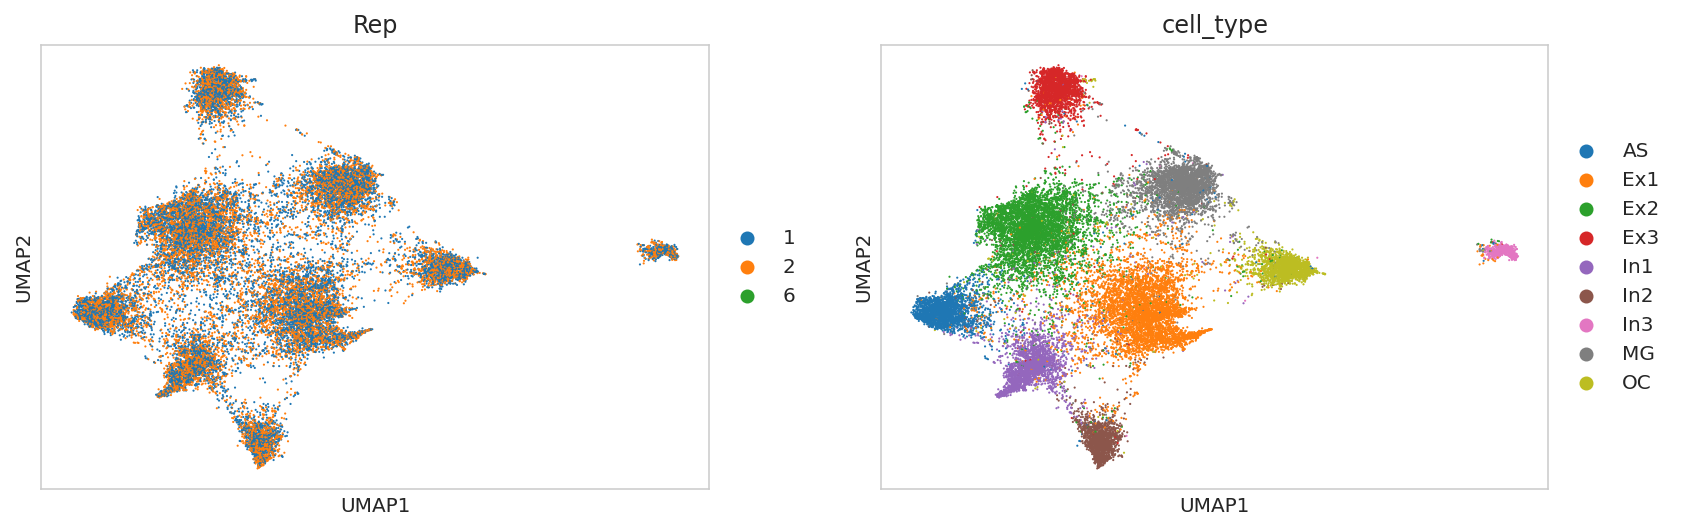

In [62]:
sc.pl.umap(scatac, color=['Rep', 'cell_type'])

### Running UMAP

In [68]:
sc.pp.neighbors(scatac, random_state=42)
sc.tl.umap(scatac, min_dist=0.01, random_state=42)

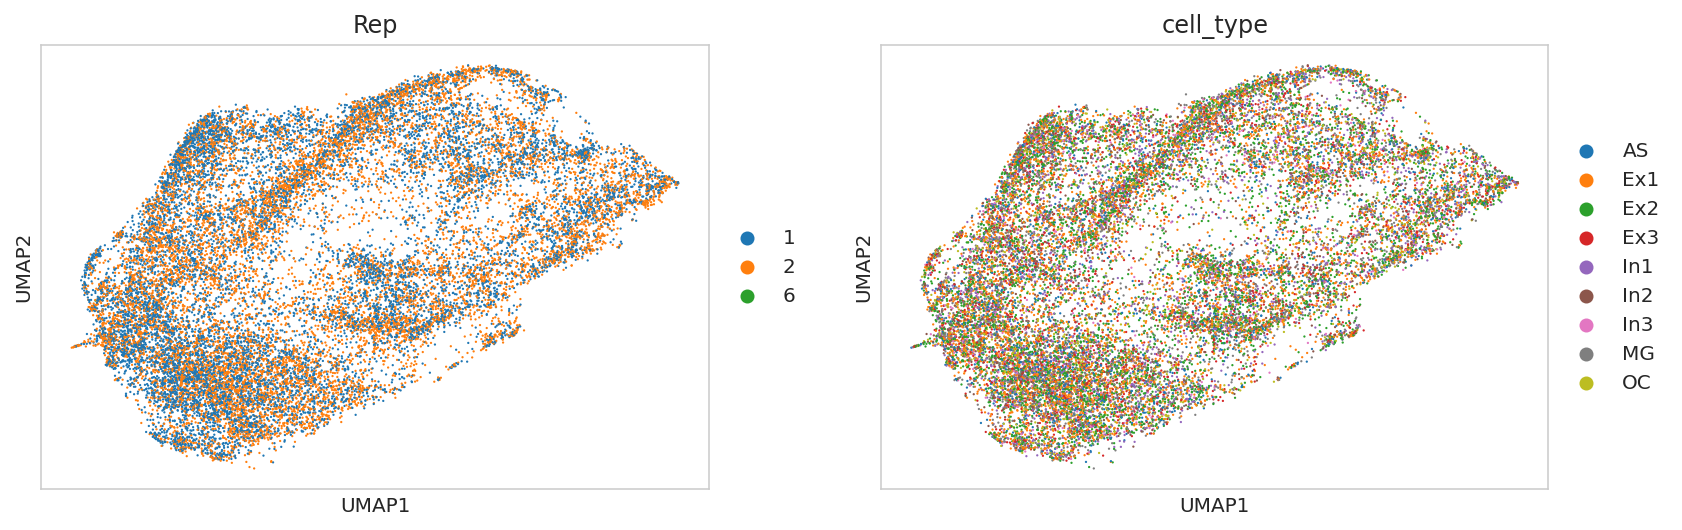

In [69]:
sc.pl.umap(scatac, color=['Rep', 'cell_type'])

---
# Save the results

### Find common paired samples

In [65]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(23231, 2777) (23231, 10054)


In [66]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 104 ms, sys: 40 ms, total: 144 ms
Wall time: 143 ms


In [67]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 284 ms, sys: 88 ms, total: 372 ms
Wall time: 389 ms
